### Load the data from Excel

In [1]:
import pandas as pd
import numpy as np
import cmdstanpy as c
import seaborn as sns
import matplotlib.pyplot as plt
c.install_cmdstan()
print(c.__version__)

Installing CmdStan version: 2.29.2
Install directory: /home/cerquide/.cmdstan
CmdStan version 2.29.2 already installed
1.0.1


In [2]:

f = pd.ExcelFile( "../data/Cumulus Expansion dataset_without_negative_CE_values.xlsx")                                                  
print(f.sheet_names)
dfs = {}
for sheet_name in f.sheet_names:
    dfs[sheet_name] = pd.read_excel(f, sheet_name, skiprows=[0,1], header=None,usecols=[1,2,3,4,5,6])

['Area method', '3distance method', 'Score method']


In [3]:
dfs['Area method']


,1,2,3,4,5,6
0,178.072184,190.503002,178.518719,170.957529,194.124455,180.524075
1,110.545249,109.025768,112.780247,108.246239,117.683475,99.680823
2,61.779680,63.414298,76.387161,70.105727,69.782141,75.691881
3,35.756752,74.652821,64.172850,47.696356,58.703652,65.581084
4,7.413434,43.492802,34.984445,29.277502,37.427337,32.186628
...,...,...,...,...,...,...
227,141.696152,142.336361,233.908814,121.368418,144.086331,260.232729
228,53.737893,47.563056,58.645541,34.494464,42.131194,62.355879
229,81.012607,72.006168,76.574489,73.516026,67.435111,81.598661
230,132.129189,139.583314,124.941917,126.100468,145.678629,155.866156


In [4]:
def get_q(v):
    return np.log((v+100)/100)

def get_matrix(xls_df, judges=3, repeats=2, do_log=True):
    objects = len(xls_df.index)
    x = np.zeros((objects, judges, repeats))
    x[:,0,0] = xls_df[1]
    x[:,0,1] = xls_df[4]
    x[:,1,0] = xls_df[2]
    x[:,1,1] = xls_df[5]
    x[:,2,0] = xls_df[3]
    x[:,2,1] = xls_df[6]
    if do_log:
        x = get_q(x)
    return x

In [215]:
def compute_kappas(method):
    x = get_matrix(dfs[method],do_log=False)
    N, J, R = x.shape
    judges = np.zeros(N*J)
    for i in range(J):
        judges[N*i:N*(i+1)]=i
    indexes = np.tile(np.arange(N),J)
    df_inter = pd.DataFrame({'oocyte':indexes,'measurer':judges})
    CI_low_inter = np.zeros(R)
    CI_high_inter = np.zeros(R)
    ICC_inter = np.zeros(R)
    for i in range(R):
        col_name = "r"+str(i)
        df_inter[col_name] = x[:,:,i].swapaxes(0,1).flatten()
        icc = pg.intraclass_corr(data=df_inter, targets='oocyte', raters='measurer', ratings=col_name, nan_policy="omit")
        icc = icc.set_index('Type')
        print("Inter expert ICCs for method " + method + " and measurement repetition "+str(i))
        print("ICC:",icc.loc["ICC2"]["ICC"]," CI95%:",icc.loc["ICC2"]["CI95%"])
        ICC_inter[i]=icc.loc["ICC2"]["ICC"]
        CI_low_inter[i] = float(icc.loc["ICC2"]["CI95%"][0])
        CI_high_inter[i] = float(icc.loc["ICC2"]["CI95%"][1])
    reps = np.zeros(N*R)
    for i in range(R):
        reps[N*i:N*(i+1)]=i
    indexesr = np.tile(np.arange(N),R)
    df_intra = pd.DataFrame({'oocyte':indexesr,'rep':reps})
    CI_low_intra = np.zeros(J)
    CI_high_intra = np.zeros(J)
    ICC_intra = np.zeros(J)
    for i in range(J):
        col_name = "a"+str(i)
        df_intra[col_name] = x[:,i,:].swapaxes(0,1).flatten()
        icc = pg.intraclass_corr(data=df_intra, targets='oocyte', raters='rep', ratings=col_name, nan_policy="omit")
        icc = icc.set_index('Type')
        print("Intra expert ICCs for method " + method + " and observer "+str(i))
        print("ICC:",icc.loc["ICC1"]["ICC"]," CI95%:",icc.loc["ICC1"]["CI95%"])
        ICC_intra[i]=icc.loc["ICC1"]["ICC"]
        CI_low_intra[i] = float(icc.loc["ICC1"]["CI95%"][0])
        CI_high_intra[i] = float(icc.loc["ICC1"]["CI95%"][1])
    return ICC_inter, CI_low_inter, CI_high_inter, ICC_intra, CI_low_intra, CI_high_intra
    

In [216]:
iccs = {}
iccs["area"] = compute_kappas("Area method")
iccs["3 distance"] = compute_kappas('3distance method')
iccs["score"] = compute_kappas('Score method')

Inter expert ICCs for method Area method and measurement repetition 0
ICC: 0.8983412277233852  CI95%: [0.88 0.92]
Inter expert ICCs for method Area method and measurement repetition 1
ICC: 0.9013158761784912  CI95%: [0.85 0.93]
Intra expert ICCs for method Area method and observer 0
ICC: 0.8724820315381185  CI95%: [0.84 0.9 ]
Intra expert ICCs for method Area method and observer 1
ICC: 0.9008245838189646  CI95%: [0.87 0.92]
Intra expert ICCs for method Area method and observer 2
ICC: 0.963238813279916  CI95%: [0.95 0.97]
Inter expert ICCs for method 3distance method and measurement repetition 0
ICC: 0.5657241039035995  CI95%: [0.49 0.63]
Inter expert ICCs for method 3distance method and measurement repetition 1
ICC: 0.5184203088685172  CI95%: [0.44 0.59]
Intra expert ICCs for method 3distance method and observer 0
ICC: 0.615781739393372  CI95%: [0.53 0.69]
Intra expert ICCs for method 3distance method and observer 1
ICC: 0.593521839169677  CI95%: [0.5  0.67]
Intra expert ICCs for metho

[0.8998285519509381, 0.5420722063860584, 0.3095538363352552]
[0.04982855195093816, 0.10207220638605835, 0.1895538363352552]
[0.03017144804906191, 0.08792779361394165, 0.1604461636647448]


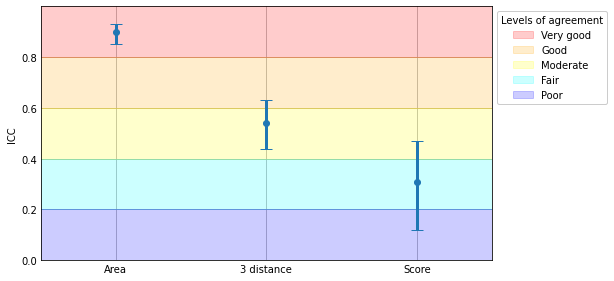

In [228]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.transforms import Bbox

x = ["Area", "3 distance", "Score"]

y = [np.mean(iccs["area"][0]), np.mean(iccs["3 distance"][0]), np.mean(iccs["score"][0])]
lowers = [y[0] - np.min(iccs["area"][1]), y[1] - np.min(iccs["3 distance"][1]), y[2]-np.min(iccs["score"][1])]
uppers = [np.max(iccs["area"][2])-y[0], np.max(iccs["3 distance"][2])-y[1], np.max(iccs["score"][2])-y[2]]
print(y)
print(lowers)
print(uppers)
yerr = [lowers,uppers]

plt.rcParams["figure.figsize"] = [16*0.4,9*0.4]
# plot:
fig, ax = plt.subplots()
#fig.figsize=(3,4)
ax.set_ylabel("ICC")
ax.errorbar(x, y, yerr, fmt='o', linewidth=3, capsize=6)
#ax.set_title("Inter expert agreement for the Area, 3 distance and Score methods")
ax.set(xlim=(-0.5, 2.5), xticks=np.arange(0, 3),
       ylim=(0, 1), yticks=np.arange(0,1,0.2 ))
r1=Rectangle((-0.5, 0.8), 3, 0.2, color="red", alpha=0.2)
r2=Rectangle((-0.5, 0.6), 3, 0.2, color="orange", alpha=0.2)
r3=Rectangle((-0.5, 0.4), 3, 0.2, color="yellow", alpha=0.2)
r4=Rectangle((-0.5, 0.2), 3, 0.2, color="cyan", alpha=0.2)
r5=Rectangle((-0.5, 0.), 3, 0.2, color="blue", alpha=0.2)
ax.add_patch(r1)
ax.add_patch(r2)
ax.add_patch(r3)
ax.add_patch(r4)
ax.add_patch(r5)
ax.legend([r1, r2, r3,r4,r5], ['Very good', 'Good', 'Moderate','Fair','Poor'], title="Levels of agreement", framealpha=1, bbox_to_anchor=(1., 1.))
plt.savefig("../figs/inter_expert_agreement.png",dpi=300.,bbox_inches=Bbox.from_extents(-0.5,-1,8,5))
plt.show()


[0.87248203 0.90082458 0.96323881 0.61578174 0.59352184 0.64176043
 0.69977657 0.11639679 0.51319562]
[0.03248203 0.03082458 0.01323881 0.08578174 0.09352184 0.08176043
 0.06977657 0.12639679 0.10319562]


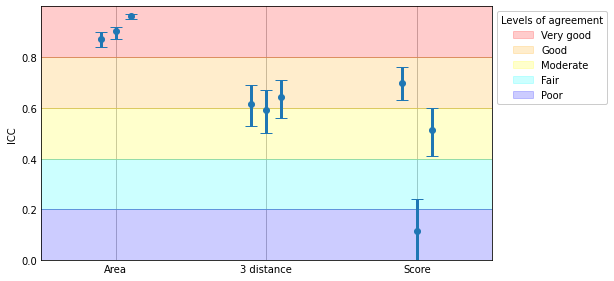

In [234]:
x = [-0.1,0.,0.1,0.9,1.,1.1,1.9,2,2.1]
y = np.hstack((iccs["area"][3], iccs["3 distance"][3], iccs["score"][3]))
print(y)


lowers = np.hstack((iccs["area"][4], iccs["3 distance"][4], iccs["score"][4]))
lowers = y-lowers
uppers = np.hstack((iccs["area"][5], iccs["3 distance"][5], iccs["score"][5]))
uppers = uppers-y
print(lowers)
yerr = [lowers,uppers]

plt.rcParams["figure.figsize"] = [16*0.4,9*0.4]
# plot:
fig, ax = plt.subplots()
#fig.figsize=(3,4)
ax.set_ylabel("ICC")
ax.errorbar(x, y, yerr, fmt='o', linewidth=3, capsize=6)
#ax.set_title("Intra expert agreement for each of the three annotators\n when using the Area, 3 distance and Score methods")
ax.set(xlim=(-0.5, 2.5), ylim=(0, 1), yticks=np.arange(0,1,0.2 ))
ax.set_xticks(np.arange(0, 3),["Area","3 distance","Score"])
r1=Rectangle((-0.5, 0.8), 3, 0.2, color="red", alpha=0.2)
r2=Rectangle((-0.5, 0.6), 3, 0.2, color="orange", alpha=0.2)
r3=Rectangle((-0.5, 0.4), 3, 0.2, color="yellow", alpha=0.2)
r4=Rectangle((-0.5, 0.2), 3, 0.2, color="cyan", alpha=0.2)
r5=Rectangle((-0.5, 0.), 3, 0.2, color="blue", alpha=0.2)
ax.add_patch(r1)
ax.add_patch(r2)
ax.add_patch(r3)
ax.add_patch(r4)
ax.add_patch(r5)
ax.legend([r1, r2, r3,r4,r5], ['Very good', 'Good', 'Moderate','Fair','Poor'], title="Levels of agreement", framealpha=1, bbox_to_anchor=(1., 1.))
plt.savefig("../figs/intra_expert_agreement.png",dpi=300.,bbox_inches=Bbox.from_extents(-0.5,-1,8,5))
plt.show()


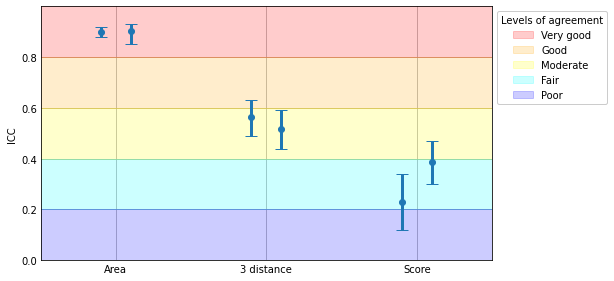

In [233]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.transforms import Bbox

#plt.style.use('_mpl-gallery')

# make data:
x = [-0.1,0.1,0.9,1.1,1.9,2.1]
#x = ["Area", "3 distance", "Score"]
y = np.hstack((iccs["area"][0], iccs["3 distance"][0], iccs["score"][0]))

lowers = np.hstack((iccs["area"][1], iccs["3 distance"][1], iccs["score"][1]))
lowers = y-lowers
uppers = np.hstack((iccs["area"][2], iccs["3 distance"][2], iccs["score"][2]))
uppers = uppers-y

yerr = [lowers,uppers]

plt.rcParams["figure.figsize"] = [16*0.4,9*0.4]
# plot:
fig, ax = plt.subplots()
#fig.figsize=(3,4)
ax.set_ylabel("ICC")
ax.errorbar(x, y, yerr, fmt='o', linewidth=3, capsize=6)
#ax.set_title("Inter expert agreement for the Area, 3 distance and Score methods")
r1=Rectangle((-0.5, 0.8), 3, 0.2, color="red", alpha=0.2)
r2=Rectangle((-0.5, 0.6), 3, 0.2, color="orange", alpha=0.2)
r3=Rectangle((-0.5, 0.4), 3, 0.2, color="yellow", alpha=0.2)
r4=Rectangle((-0.5, 0.2), 3, 0.2, color="cyan", alpha=0.2)
r5=Rectangle((-0.5, 0.), 3, 0.2, color="blue", alpha=0.2)
ax.set(xlim=(-0.5, 2.5), ylim=(0, 1), yticks=np.arange(0,1,0.2 ))
ax.set_xticks(np.arange(0, 3),["Area","3 distance","Score"])
ax.add_patch(r1)
ax.add_patch(r2)
ax.add_patch(r3)
ax.add_patch(r4)
ax.add_patch(r5)
ax.legend([r1, r2, r3,r4,r5], ['Very good', 'Good', 'Moderate','Fair','Poor'], title="Levels of agreement", framealpha=1, bbox_to_anchor=(1., 1.))
plt.savefig("../figs/inter_expert_agreement2.png",dpi=300.,bbox_inches=Bbox.from_extents(-0.5,-1,8,5))
plt.show()